In [1]:
from skykatana import SkyMaskPipe
from pathlib import Path

# Quick intro or how to swing a Skykatana
-----------------
Starting from an input catalog of sources, ``Skykatana`` can create a pixelized mask or map in healsparse format, excluding areas due to various reasons such as bright stars, patches with low depth, etc. It also allows to combine this mask with arbitrary regions defined by the user

Basic usage: 
* **build_footprint_mask(), build_patch_mask(), build_holes_mask(), etc.** are used to produce individual masks
* **combine_mask()** merge the maps create above to general a final mask
* **plot()** can quickly visualize a mask, make zooms and overplot stars
* **makerans()** can generate randoms over a mask
* **apply()** can cut out sources outside of a given mask

## Define inputs

In [2]:
BASEPATH = Path('../example_data')

# Input HATS catalog (these are HSC galaxies)
HATSCAT = BASEPATH / 'hscx_minispring_gal/'

# Bright star regions of HSC
STARS_REGIONS     = BASEPATH / 'hsc_aux/stars_iband.parquet' 
BOX_STARS_REGIONS = BASEPATH / 'hsc_aux/starboxes_iband.parquet' 

# HSC patches and QA patch list ###################################### 
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = [BASEPATH / 'hsc_aux/tracts_patches_minispring.parquet']
QA_FILE        = BASEPATH / 'hsc_aux/patch_qa.csv'

# Extended sources to mask out
ELLIP_REGIONS = BASEPATH / 'hsc_aux/extended_sources.dat'

# User defined masks
USER_CIRCLE_REGIONS = BASEPATH / 'hsc_aux/user_circs.dat' 
USER_POLY_REGIONS   = BASEPATH / 'hsc_aux/user_polys.dat'

## 1. Create the pipeline and run! 
-----------

After SkyMaskPipe is instanciated, you can build masks (a.k.a. maps) due to various effects. Each of them is independent and can be run (or not) individually. Their results are **healsparse maps** we call `stages`, which stored within the class as:
* **`Footprint stage`** :: holds the footprint map created from the input catalog **[SkyMaskPipe.foot]**
* **`Patchmap stage`** :: holds the map created from HSC patches matching some criteria **[SkyMaskPipe.patchmap]**
* **`Holemap stage`** :: holds the map created from circles & boxes due to bright stars HSC, to mask out **[SkyMaskPipe.holemap]**
* **`Extendedmap stage`** :: holds the map created from a list of elliptical sources to mask out **[SkyMaskPipe.extendedmap]**
* **`Usermap stage`** :: holds the footprint map created from user defined regions **[SkyMaskPipe.usermap]**

Then, all/some of these masks can be combined by `combine_mask()` into:
* **`Mask stage`** :: holds the **final** mask after combining the maps above **[SkyMaskPipe.mask]**   

In [7]:
mkp = SkyMaskPipe(order_out=15)
mkp.build_footprint_mask(hatscat=HATSCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS)
mkp.build_extended_mask(ellip_regs=ELLIP_REGIONS)
mkp.combine_mask()

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating HATS catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
--- Footprint map area                    : 69.35790724770318
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../example_data/hsc_aux/tracts_patches_minispring.parquet
    Order :: 13
    Patches with QA                       : 3708
    Patches with QA fulfilling conditions : 2003
    Surviving patch pixels                : 1062650
--- Patch map area                        : 54.43575391135537
BUILDING BRIGHT STAR HOLES MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../example_data/hsc_aux/stars_iband.parquet
    Order :: 15
    done
--- Pixelating boxes from ../example_data/hsc_aux/starboxes_iband.parquet
    Order :: 15
    done
--- Holes map area                        : 16.295306306474806
BUILDING EXTENDED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating ellipses from ../exa

## 2. Explore some plots
-------------------

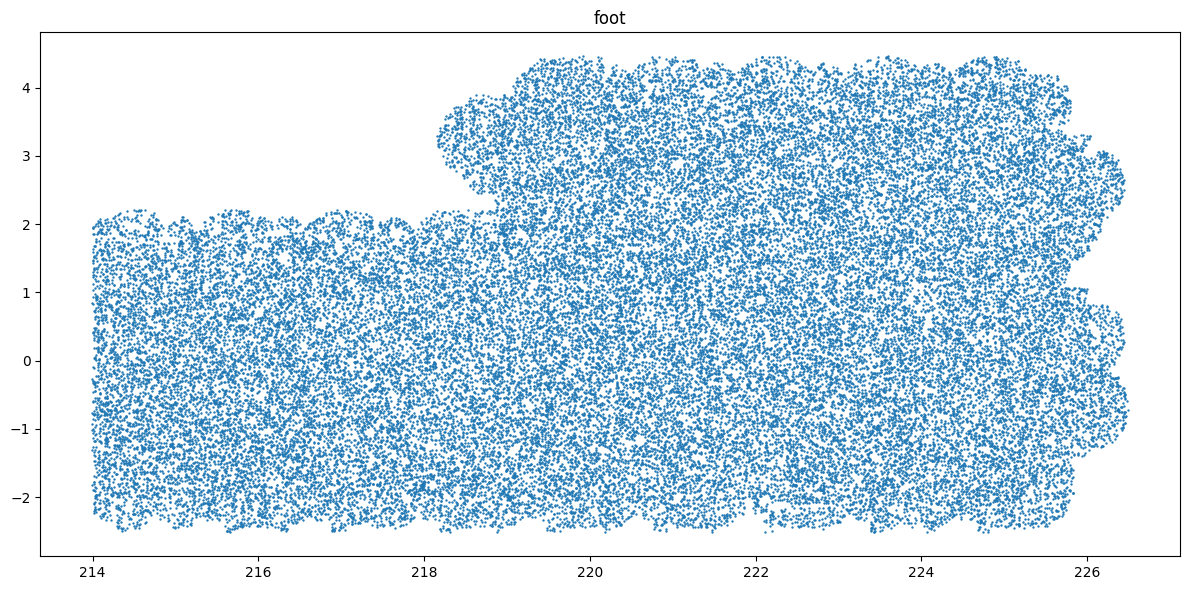

In [4]:
# plot the footprint
mkp.plot(stage='foot')

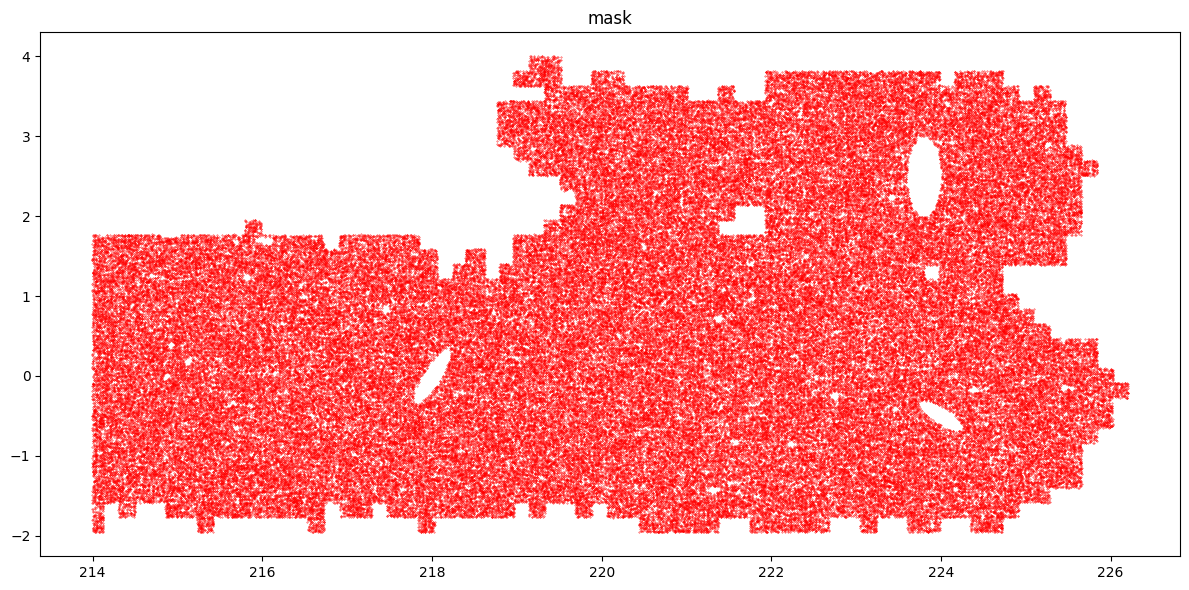

In [8]:
# plot the final mask
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r')

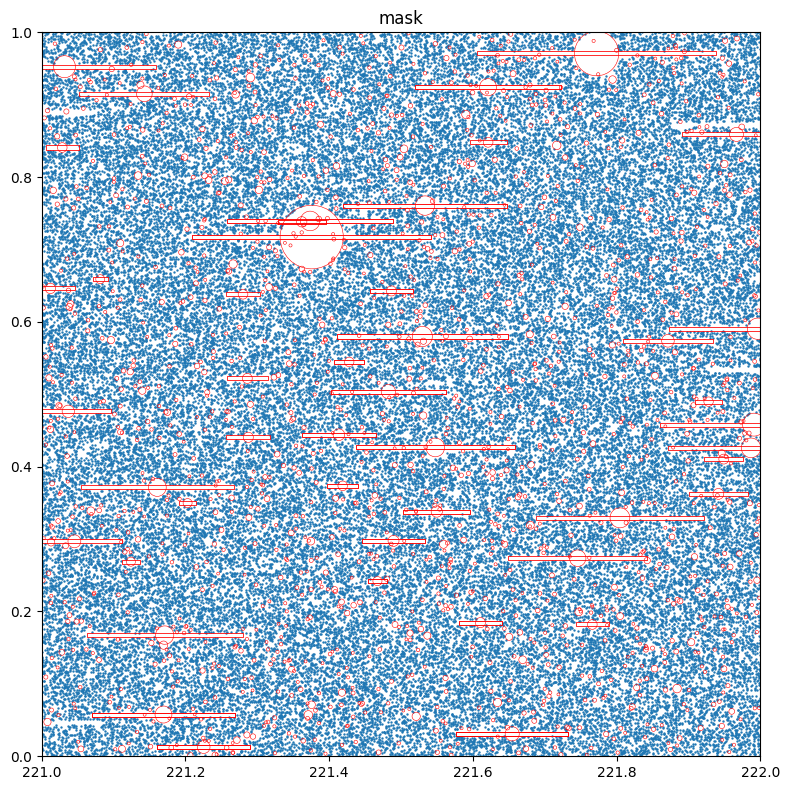

In [6]:
# plot a zoom of the final mask
mkp.plot(stage='mask', nr=4_000_000, figsize=[8,8], xwin=[221,222], ywin=[0,1], plot_stars=True, plot_boxes=True)

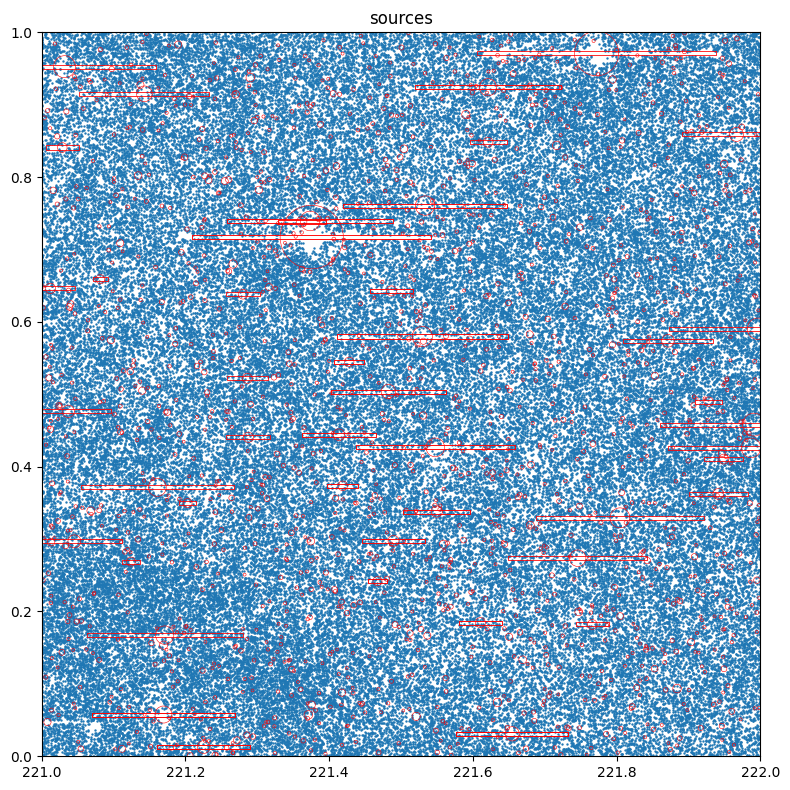

In [7]:
# plot the same figure, but using the actual HSC sources instead of randoms generated over the mask
mkp.plot(stage='mask', nr=4_000_000, figsize=[8,8], xwin=[221,222], ywin=[0,1], plot_stars=True, plot_boxes=True, use_srcs=True)

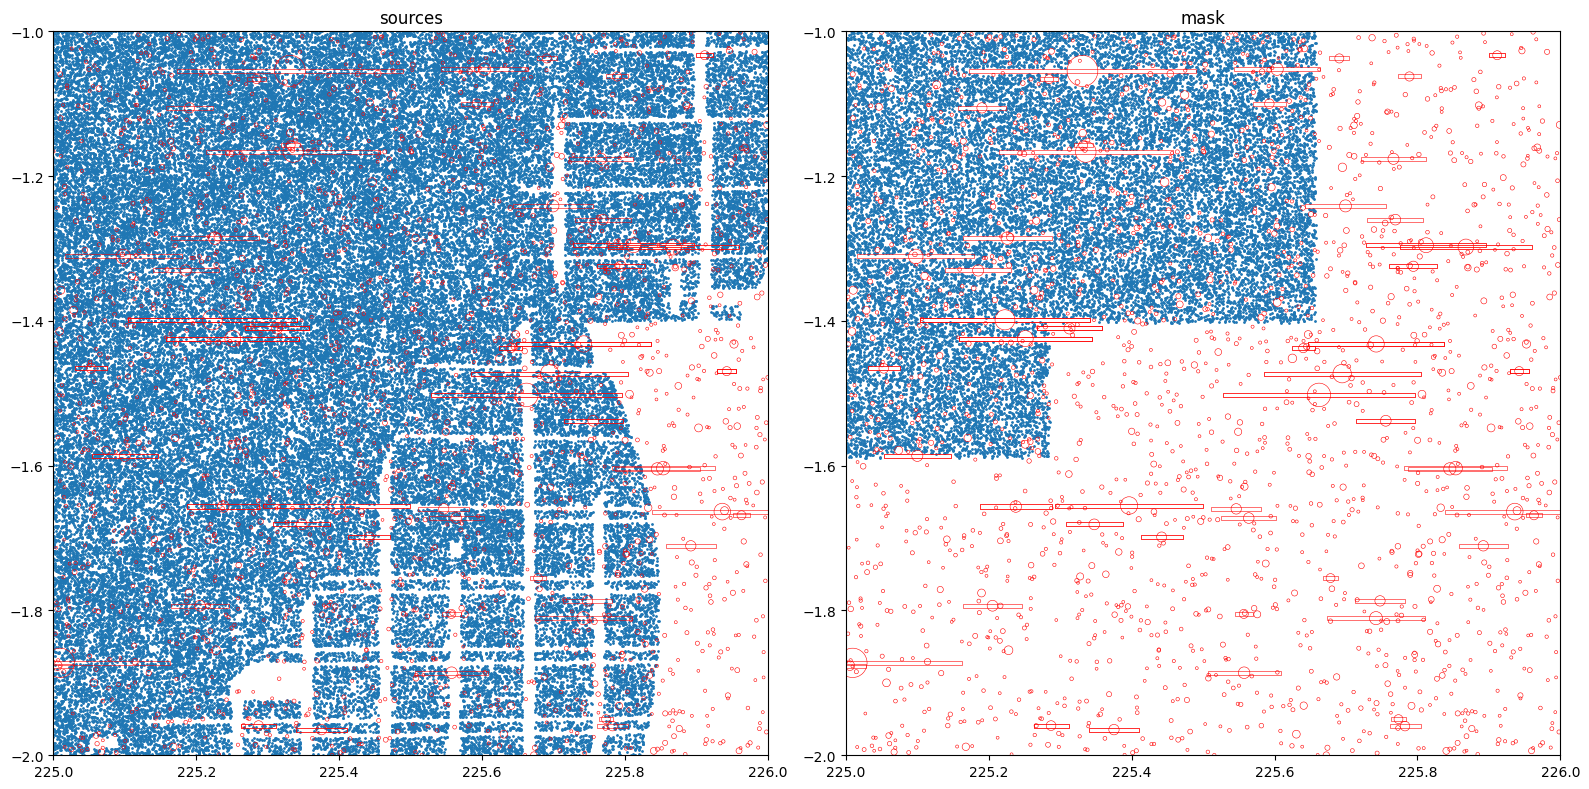

In [8]:
# Plot sources on the left, and randoms over the final mask on the right
mkp.plot2compare(stage='mask', nr=4_000_000, s=1, figsize=[16,8], xwin=[225,226], ywin=[-2,-1], 
                 plot_stars=True, plot_boxes=True)

## 3. Generate randoms / Apply final mask to input catalog / Save pipeline to disk
---------

In [9]:
rands = mkp.makerans(stage='mask', nr=500_000)
rands[0:10]

<Table length=10>
        ra                 dec         
     float64             float64       
------------------ --------------------
216.79172694683075   1.0039252524331188
 217.8343230485916  -0.3568569240347848
220.13868391513824 -0.19226563251105755
 220.9648633003235   -1.246585102751566
 219.6155297756195   3.2740477298096167
214.00747060775757   1.4727737323258914
221.03860795497891   1.6745089785520084
 221.9301152229309    2.673773640181405
220.50227880477902  -0.7832695096946275
216.65556728839874  -0.7050117028327647

In [10]:
# Use apply() to return a catalog filtered by any mask stage
import lsdb
srcs = lsdb.read_hats(HATSCAT, columns=['ra','dec']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra','dec'])

6023508 sources within mask


In [11]:
# Save SkyMaskPipe object to disk
mkp.write(BASEPATH / 'minispring.maskpipe')

../example_data/minispring.maskpipe saved to disk


## 4. Now add a user-defined mask
-------------

In [12]:
# Our user defined regions are just a couple of circles and some boxes
mkp.build_user_mask(circ_uregs=USER_CIRCLE_REGIONS, poly_uregs=USER_POLY_REGIONS)
mkp.combine_mask(apply_extendedmap=False, apply_usermap=True)        # By default apply_usermap=False

BUILDING USER DEFINED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../example_data/hsc_aux/user_circs.dat
    Order :: 15
    done
--- Pixelating polygons from ../example_data/hsc_aux/user_polys.dat
    Order :: 15
--- User map area                         : 1.2559277140625398
COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 1.1014320366880248


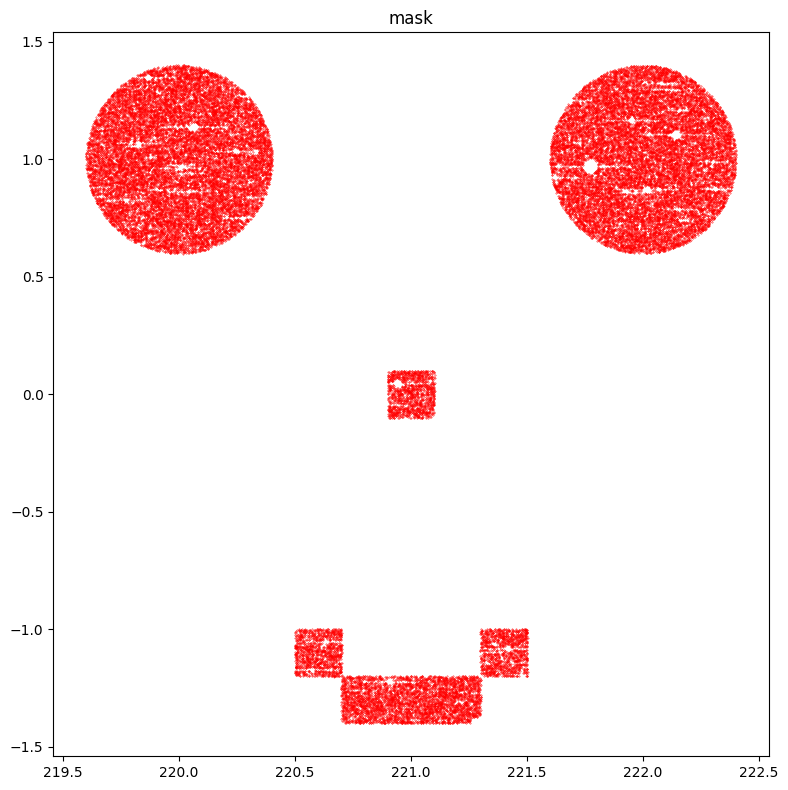

In [13]:
mkp.plot(stage='mask', nr=50_000, s=0.09, color='r', figsize=[8,8])

## 5. Apply custom HSC patch filtering
----------

In [5]:
mkp_custom = SkyMaskPipe()
mkp_custom.build_footprint_mask(hatscat=HATSCAT)
mkp_custom.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, filt='(imag_psf_depth>26.3)')
mkp_custom.combine_mask(apply_holemap=False, apply_extendedmap=False)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating HATS catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
--- Footprint map area                    : 69.35790724770318
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../example_data/hsc_aux/tracts_patches_minispring.parquet
    Order :: 13
    Patches with QA                       : 3708
    Patches with QA fulfilling conditions : 1167
    Surviving patch pixels                : 633006
--- Patch map area                        : 32.426630443148184
COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- footprint order upgraded to: 15
--- patchmap order upgraded to:  15
--- Combined map area                     : 31.036294211173313


In [16]:
# Recombine the final mask again without the usermap of the "smile face" above
mkp.combine_mask()    # By default apply_usermap=False

COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 45.8904540815507


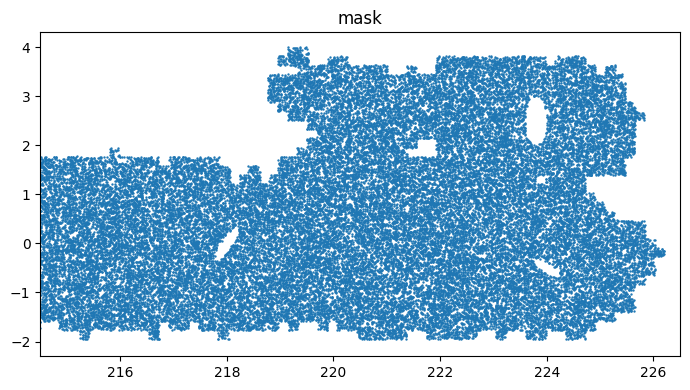

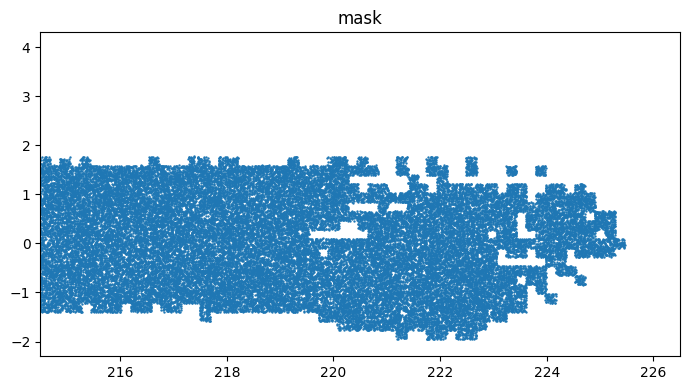

In [6]:
# Now compare the default filter applied before and the new i-band only patch filter
mkp.plot(stage='mask', figsize=[7,4], xwin=[214.5, 226.5], ywin=[-2.3, 4.3])
mkp_custom.plot(stage='mask', figsize=[7,4], xwin=[214.5, 226.5], ywin=[-2.3, 4.3])

* Note setting `filt=None` applies no filtering and therefore all patches will be pixelized into the patchmap.
* Note leaving `filt` unspecified will use the default filtering recipe, which impose minimum values on gri depths in order to select a more uniform coverage :: (gmag_psf_depth>26.2) and (rmag_psf_depth>25.9) and (imag_psf_depth>25.7)